# ADCC experiment analysis

## Prerequisite: download ADCC data

The following code fetches an experiment folder from Zotero (https://zenodo.org/records/10650279), that is perfectly compatible with the software Celldetective, for demonstration purposes. Here we explore how to use some specific functions that are under the hood of the GUI. To optimize memory constraints, we developed a subprocess-based formulation for all the processing modules, that the software exploits. This approach locates a position in the experiment folder, reads the experiment metadata and writes directly on the disk the changes and output. In parallel, we propose a more direct and notebook-friendly functions that take input data and return the transformed or new data (*e.g.* image input, instance segmentation image output for the segmentation function).

* "position" mode: the subprocess approach
* "direct" mode: the i/o approach

In [1]:
from celldetective.utils import download_zenodo_file
import os
import numpy as np
import matplotlib.pyplot as plt

output_directory = '.'
# Download demo ADCC experiment locally
if not os.path.exists(os.sep.join([output_directory,'demo_adcc'])):
    download_zenodo_file('demo_adcc', output_directory)
exp = os.sep.join([output_directory, 'demo_adcc'])

api_mode = "direct" # "position" or "direct"
assert api_mode in ["position", "direct"],"Please select a valid api mode"

100%|████████████████████████████████████████| 896M/896M [01:24<00:00, 11.1MB/s]


## Content of the experiment

The ***demo_adcc*** experiment contains a single well and a single position. All information about the experiment is contained in the configuration file of the experiment (channel order, biological conditions, spatio-temporal calibration...). Here we explore the contents of the wells and load the movie stack assoiated to the unique position. 

We imaged a co-culture of MCF-7 breast cancer cells (targets) and human primary NK cells (effectors), interacting in the presence of bispecific antibodies, to measure antibody dependent cellular cytotoxicity (ADCC). The nuclei of all cells are marked with the Hoechst nuclear stain, the dead nuclei with the propidium iodide nuclear stain, the cytoplasm of the NK cells with CFSE. The system in epifluorescence and brightfield 20X magnification. We are interested in detecting lysis events of the MCF-7 cells from the PI stain.

Experiment configuration file: ./demo_adcc/config.ini
Wells: ['./demo_adcc/W1/']
For well W1, found positions:  ['./demo_adcc/W1/100/']
Found 4 channels: ['brightfield_channel' 'dead_nuclei_channel' 'effector_fluo_channel'
 'live_nuclei_channel'], at indices [0 1 2 3]
Found stack of shape (44, 2048, 2048, 4)


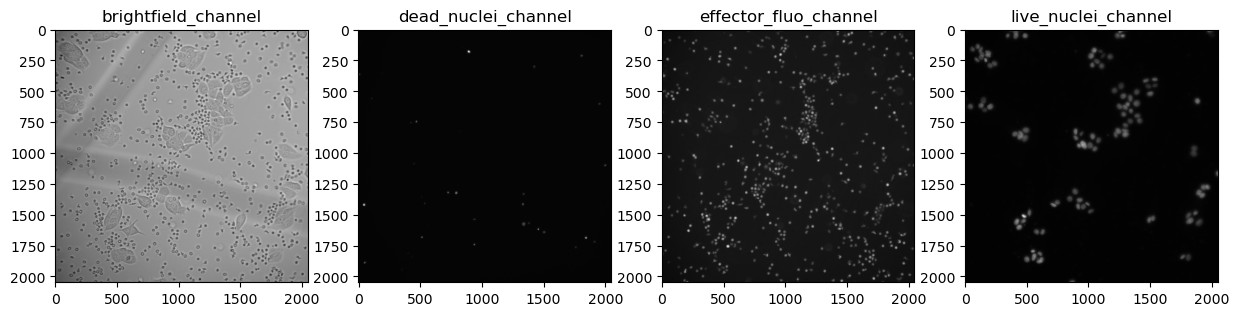

In [2]:
from celldetective.io import get_experiment_wells, get_positions_in_well, get_config, load_experiment_tables, extract_well_name_and_number, \
                             extract_experiment_channels, locate_stack, get_spatial_calibration, get_temporal_calibration

config = get_config(exp)
print(f'Experiment configuration file: {config}')
wells = get_experiment_wells(exp)
PxToUm = get_spatial_calibration(exp)
FrameToMin = get_temporal_calibration(exp)

print(f'Wells: {wells}')
pos = None
for well in wells:
    well_name, well_nbr = extract_well_name_and_number(well)
    positions = get_positions_in_well(well)
    print(f"For well {well_name}, found positions: ",positions)
    if len(positions)>0:
        pos = positions[0] # detect the only position in the demo

channel_names, channel_indices = extract_experiment_channels(config)
print(f"Found {len(channel_names)} channels: {channel_names}, at indices {channel_indices}")

# For the single position
stack = locate_stack(pos)
print(f"Found stack of shape {stack.shape}")

fig,ax = plt.subplots(1,4,figsize=(15,5))
for ch in range(stack.shape[-1]):
    ax[ch].imshow(stack[0,:,:,ch],cmap="gray")
    ax[ch].set_title(channel_names[channel_indices==ch][0])
plt.show()

## Processing

### Segmentation

Looking for MCF7_h_versatile in /home/limozin/anaconda3/lib/python3.11/site-packages/celldetective/models/segmentation*//
Loading input configuration from 'config_input.json'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.663765, nms_thresh=0.4.
StarDist model MCF7_h_versatile successfully loaded


frame: 100%|████████████████████████████████████| 44/44 [01:12<00:00,  1.64s/it]


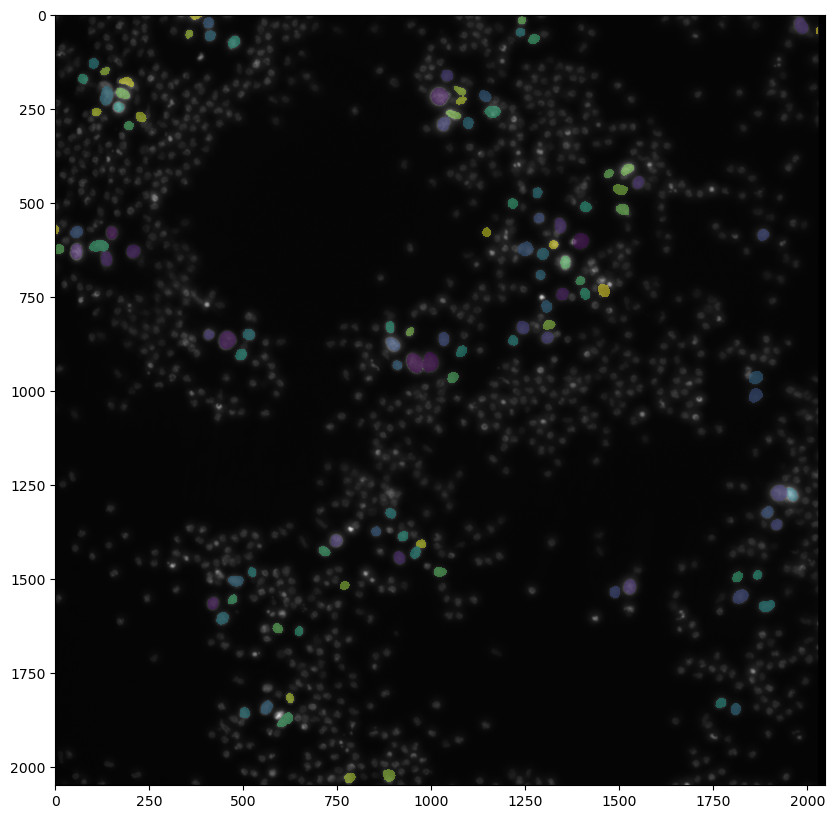

In [3]:
from celldetective.segmentation import segment_at_position, segment

model_name = "MCF7_h_versatile"
population = "targets"

if api_mode=="position":
    
    labels = segment_at_position(pos, population, model_name, use_gpu=True, return_labels=True, view_on_napari=False)
    
elif api_mode=="direct":
        
    labels = segment(stack, model_name, channels=list(channel_names), spatial_calibration=PxToUm, view_on_napari=False,
    			use_gpu=False) 
    
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(stack[-1,:,:,-1],cmap="gray")
ax.imshow(np.ma.masked_where(labels[-1]==0, labels[-1]),alpha=0.5)
plt.show()

### Tracking

frame: 100%|████████████████████████████████████| 44/44 [00:00<00:00, 63.83it/s]
[INFO][2024/02/21 04:59:02 PM] Objects are of type: <class 'pandas.core.frame.DataFrame'>
[INFO][2024/02/21 04:59:02 PM] Loaded btrack: /home/limozin/anaconda3/lib/python3.11/site-packages/btrack/libs/libtracker.so
[INFO][2024/02/21 04:59:02 PM] Starting BayesianTracker session
[INFO][2024/02/21 04:59:02 PM] Loading configuration file: /home/limozin/.cache/btrack-examples/examples/cell_config.json
[INFO][2024/02/21 04:59:02 PM] Objects are of type: <class 'list'>
[INFO][2024/02/21 04:59:02 PM] Starting tracking... 
[INFO][2024/02/21 04:59:02 PM] Update using: ['MOTION']
[INFO][2024/02/21 04:59:02 PM] Tracking objects in frames 0 to 44 (of 44)...
[INFO][2024/02/21 04:59:02 PM]  - Timing (Bayesian updates: 3.16ms, Linking: 0.34ms)
[INFO][2024/02/21 04:59:02 PM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2024/02/21 04:59:02 PM] SUCCESS.
[INFO][2024/02/21 04:59:02 PM]  - Found 217 tracks in 44 fram

GLPK Integer Optimizer 5.0
868 rows, 721 columns, 1022 non-zeros
721 integer variables, all of which are binary
Preprocessing...
434 rows, 721 columns, 1022 non-zeros
721 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 434
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
434 rows, 721 columns, 1022 non-zeros
*     0: obj =   1.237059957e+03 inf =   0.000e+00 (158)
*   163: obj =   3.590058227e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   163: mip =     not found yet >=              -inf        (1; 0)
+   164: >>>>>   3.594074202e+02 >=   3.594074202e+02 < 0.1% (2; 0)
+   164: mip =   3.594074202e+02 >=     tree is empty   0.0% (0; 3)
INTEGER OPTIMAL SOLUTION FOUND
0        0.0
1        1.0
2        2.0
3        3.0
4        4.0
        ... 
4

,TRACK_ID,FRAME,POSITION_Y,POSITION_X,POSITION_X_um,POSITION_Y_um,t,state,generation,root,parent,dummy,class_id,class_firstdetection,t_firstdetection
0,1.0,0.0,700.561626,1396.756163,434.670518,218.014778,0.0,5.0,0.0,1.0,1.0,False,70.0,2.0,-1.0
1,1.0,1.0,700.735432,1396.835901,434.695332,218.068866,1.0,5.0,0.0,1.0,1.0,False,73.0,2.0,-1.0
2,1.0,2.0,700.738491,1398.237212,435.131420,218.069818,2.0,5.0,0.0,1.0,1.0,False,68.0,2.0,-1.0
3,1.0,3.0,701.011728,1399.336420,435.473494,218.154850,3.0,5.0,0.0,1.0,1.0,False,50.0,2.0,-1.0
4,1.0,4.0,701.425737,1399.958509,435.667088,218.283689,4.0,5.0,0.0,1.0,1.0,False,39.0,2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,110.0,39.0,68.906618,474.696283,147.725483,21.443740,39.0,5.0,0.0,110.0,110.0,False,31.0,2.0,-1.0
4616,110.0,40.0,70.289240,475.931885,148.110003,21.874011,40.0,5.0,0.0,110.0,110.0,False,30.0,2.0,-1.0
4617,110.0,41.0,70.929947,474.309107,147.604994,22.073400,41.0,5.0,0.0,110.0,110.0,False,72.0,2.0,-1.0
4618,110.0,42.0,72.047187,475.595281,148.005252,22.421085,42.0,5.0,0.0,110.0,110.0,False,55.0,2.0,-1.0


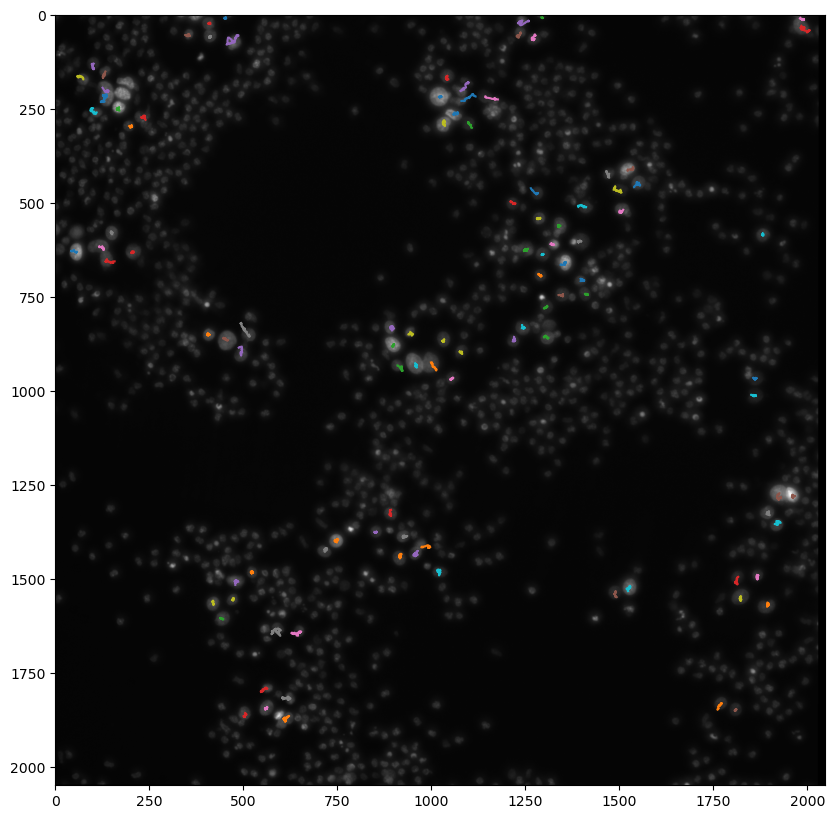

In [4]:
from celldetective.tracking import track_at_position, track

population = "targets"

if api_mode=="position":
    # not shown: reads the configs/tracking_instructions_targets.json in the experiment folder    
    tracks = track_at_position(pos, population, return_tracks=True)
    
elif api_mode=="direct":
        
    tracks = track(labels, configuration=None, stack=stack, spatial_calibration=PxToUm, features=None, channel_names=list(channel_names),
    		  view_on_napari=False, volume=(stack.shape[1],stack.shape[2]), optimizer_options = {'tm_lim': int(12e4)}, track_kwargs={'step_size': 100},
              clean_trajectories_kwargs={"minimum_tracklength": 10,"remove_not_in_first": True,"interpolate_position_gaps": True,"extrapolate_tracks_post": True})

display(tracks)
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(stack[-1,:,:,-1],cmap="gray")
for tid,group in tracks.groupby("TRACK_ID"):
    ax.plot(group.POSITION_X, group.POSITION_Y)
plt.show()

### Measurements


In [5]:
from celldetective.measure import measure_at_position, measure

population = "targets"

if api_mode=="position":
    # not shown: reads the configs/measurement_instructions_targets.json in the experiment folder
    props =  measure_at_position(pos, population, return_measurements=True)

elif api_mode=="direct":
    # Perform custom measurements: features store regionprops measurements, define isotropic measurements, edge measurements...
    props = measure(stack=stack, labels=labels, trajectories=tracks, channel_names=list(channel_names),
    			features=["area", "intensity_mean"], intensity_measurement_radii=[10], isotropic_operations=['mean'], border_distances=[5],
    			haralick_options=None, clear_previous=True)

props['position'] = pos    
display(props.head(10))

frame: 100%|████████████████████████████████████| 44/44 [00:21<00:00,  2.09it/s]


,TRACK_ID,FRAME,POSITION_X,POSITION_Y,POSITION_X_um,POSITION_Y_um,class_id,t,state,generation,...,area,brightfield_channel_mean,dead_nuclei_channel_mean,effector_fluo_channel_mean,live_nuclei_channel_mean,brightfield_channel_mean_0_edge,dead_nuclei_channel_mean_1_edge,effector_fluo_channel_mean_2_edge,live_nuclei_channel_mean_3_edge,position
0,1.0,0.0,1396.756163,700.561626,434.670518,218.014778,70.0,0.0,5.0,0.0,...,1501.0,38232.740173,154.247835,286.575616,2774.174550,38475.077047,154.600321,286.459069,2276.935795,./demo_adcc/W1/100/
1,1.0,1.0,1396.835901,700.735432,434.695332,218.068866,73.0,1.0,5.0,0.0,...,1493.0,38223.204287,154.847287,282.089082,2865.956463,38463.352090,154.181672,281.617363,2339.065916,./demo_adcc/W1/100/
2,1.0,2.0,1398.237212,700.738491,435.131420,218.069818,68.0,2.0,5.0,0.0,...,1564.0,37705.524936,152.776215,282.476982,2651.171995,37720.065934,152.485086,282.042386,2171.981162,./demo_adcc/W1/100/
3,1.0,3.0,1399.336420,701.011728,435.473494,218.154850,50.0,3.0,5.0,0.0,...,1620.0,37753.377778,155.898148,274.654321,2533.787037,37585.301242,156.017081,275.142857,2075.636646,./demo_adcc/W1/100/
4,1.0,4.0,1399.958509,701.425737,435.667088,218.283689,39.0,4.0,5.0,0.0,...,1663.0,37881.357787,156.536981,278.064943,2439.919423,37825.534622,156.603865,277.827697,1991.256039,./demo_adcc/W1/100/
5,1.0,5.0,1401.343329,701.337209,436.098044,218.256140,34.0,5.0,5.0,0.0,...,1634.0,37298.276622,156.333537,297.177479,2511.299266,36309.192901,156.737654,311.595679,2082.021605,./demo_adcc/W1/100/
6,1.0,6.0,1401.781609,702.369631,436.234437,218.577429,46.0,6.0,5.0,0.0,...,1653.0,37217.955838,158.432547,271.681791,2442.185723,37226.064771,158.829384,271.415482,2021.671406,./demo_adcc/W1/100/
7,1.0,7.0,1401.902884,702.979988,436.272178,218.767372,39.0,7.0,5.0,0.0,...,1699.0,37107.680989,160.406121,277.908181,2372.728664,36971.533997,162.505804,278.119403,1916.273632,./demo_adcc/W1/100/
8,1.0,8.0,1402.699602,702.622942,436.520116,218.656259,43.0,8.0,5.0,0.0,...,1761.0,35808.973878,160.210676,265.400341,2261.751846,36418.507317,162.043902,266.764228,1842.352846,./demo_adcc/W1/100/
9,1.0,9.0,1402.253012,703.926443,436.381137,219.061909,71.0,9.0,5.0,0.0,...,1577.0,36380.857958,159.191503,257.051363,2846.203551,38155.147595,161.679934,258.174129,2203.245439,./demo_adcc/W1/100/


### Signal analysis


Looking for lysis_PI_area in /home/limozin/anaconda3/lib/python3.11/site-packages/celldetective/models/signal_detection//
The available_signals are :  ['TRACK_ID', 'FRAME', 'POSITION_X', 'POSITION_Y', 'POSITION_X_um', 'POSITION_Y_um', 'class_id', 't', 'state', 'generation', 'root', 'parent', 'class_firstdetection', 't_firstdetection', 'brightfield_channel_circle_10_mean', 'dead_nuclei_channel_circle_10_mean', 'effector_fluo_channel_circle_10_mean', 'live_nuclei_channel_circle_10_mean', 'area', 'brightfield_channel_mean', 'dead_nuclei_channel_mean', 'effector_fluo_channel_mean', 'live_nuclei_channel_mean', 'brightfield_channel_mean_0_edge', 'dead_nuclei_channel_mean_1_edge', 'effector_fluo_channel_mean_2_edge', 'live_nuclei_channel_mean_3_edge', 'position']
Pattern test for signal dead_nuclei_channel_circle_10_mean:  [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, Fals

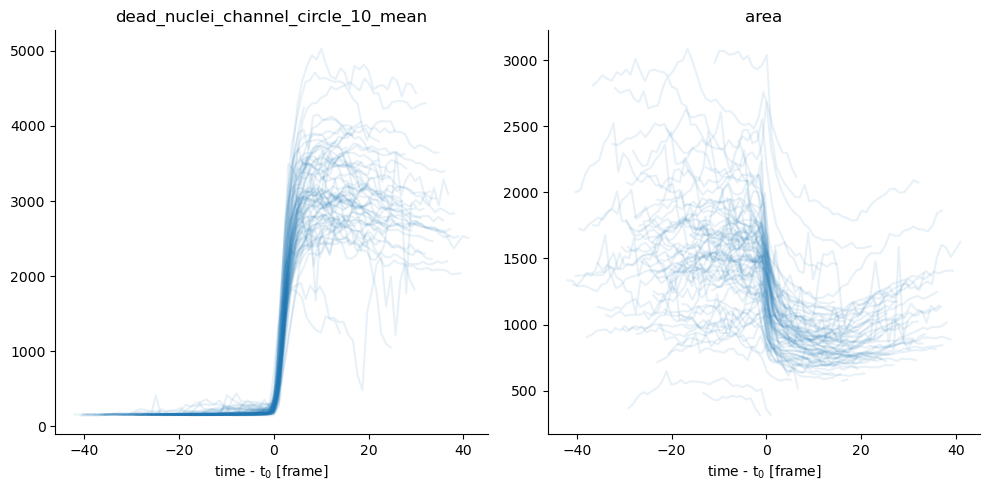

,TRACK_ID,FRAME,POSITION_X,POSITION_Y,POSITION_X_um,POSITION_Y_um,class_id,t,state,generation,...,brightfield_channel_mean_0_edge,dead_nuclei_channel_mean_1_edge,effector_fluo_channel_mean_2_edge,live_nuclei_channel_mean_3_edge,position,class_lysis,t_lysis,status_lysis,status_color,class_color
0,1.0,0.0,1396.756163,700.561626,434.670518,218.014778,70.0,0.0,5.0,0.0,...,38475.077047,154.600321,286.459069,2276.935795,./demo_adcc/W1/100/,0.0,25.564152,0.0,tab:blue,tab:red
1,1.0,1.0,1396.835901,700.735432,434.695332,218.068866,73.0,1.0,5.0,0.0,...,38463.352090,154.181672,281.617363,2339.065916,./demo_adcc/W1/100/,0.0,25.564152,0.0,tab:blue,tab:red
2,1.0,2.0,1398.237212,700.738491,435.131420,218.069818,68.0,2.0,5.0,0.0,...,37720.065934,152.485086,282.042386,2171.981162,./demo_adcc/W1/100/,0.0,25.564152,0.0,tab:blue,tab:red
3,1.0,3.0,1399.336420,701.011728,435.473494,218.154850,50.0,3.0,5.0,0.0,...,37585.301242,156.017081,275.142857,2075.636646,./demo_adcc/W1/100/,0.0,25.564152,0.0,tab:blue,tab:red
4,1.0,4.0,1399.958509,701.425737,435.667088,218.283689,39.0,4.0,5.0,0.0,...,37825.534622,156.603865,277.827697,1991.256039,./demo_adcc/W1/100/,0.0,25.564152,0.0,tab:blue,tab:red
5,1.0,5.0,1401.343329,701.337209,436.098044,218.256140,34.0,5.0,5.0,0.0,...,36309.192901,156.737654,311.595679,2082.021605,./demo_adcc/W1/100/,0.0,25.564152,0.0,tab:blue,tab:red
6,1.0,6.0,1401.781609,702.369631,436.234437,218.577429,46.0,6.0,5.0,0.0,...,37226.064771,158.829384,271.415482,2021.671406,./demo_adcc/W1/100/,0.0,25.564152,0.0,tab:blue,tab:red
7,1.0,7.0,1401.902884,702.979988,436.272178,218.767372,39.0,7.0,5.0,0.0,...,36971.533997,162.505804,278.119403,1916.273632,./demo_adcc/W1/100/,0.0,25.564152,0.0,tab:blue,tab:red
8,1.0,8.0,1402.699602,702.622942,436.520116,218.656259,43.0,8.0,5.0,0.0,...,36418.507317,162.043902,266.764228,1842.352846,./demo_adcc/W1/100/,0.0,25.564152,0.0,tab:blue,tab:red
9,1.0,9.0,1402.253012,703.926443,436.381137,219.061909,71.0,9.0,5.0,0.0,...,38155.147595,161.679934,258.174129,2203.245439,./demo_adcc/W1/100/,0.0,25.564152,0.0,tab:blue,tab:red


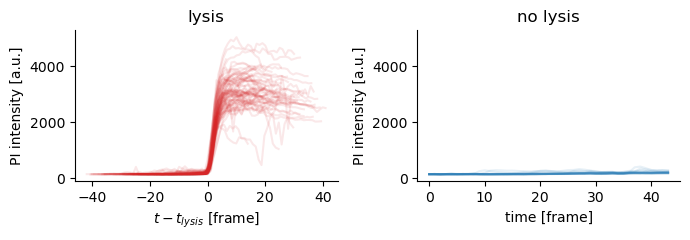

In [6]:
from celldetective.signals import analyze_signals_at_position, analyze_signals

model_name = "lysis_PI_area"
population = "targets"
feature_to_plot = 'dead_nuclei_channel_circle_10_mean'

if api_mode=="position":
    
    df_class = analyze_signals_at_position(pos, model_name, population, use_gpu=True, return_table=True)

elif api_mode=="direct":
        
    df_class = analyze_signals(props, model_name, interpolate_na=True, selected_signals=None, plot_outcome=True, output_dir=None)


df_class['position'] = pos
display(df_class.head(10))
# Plot results
fig,ax = plt.subplots(1,2,figsize=(7,2.5))
for tid, group in df_class.loc[df_class['class_lysis']==0].groupby('TRACK_ID'):
    timeline = group['FRAME'].values
    pi_signal = group[feature_to_plot].values
    t_lysis = group['t_lysis'].values[0]
    ax[0].plot(timeline - t_lysis, pi_signal,c='tab:red',alpha=0.1)
    ymin,ymax = ax[0].get_ylim()
    ax[0].set_title('lysis')
    ax[0].set_xlabel(r'$t - t_{lysis} $ [frame]')

for tid, group in df_class.loc[df_class['class_lysis']==1].groupby('TRACK_ID'):
    timeline = group['FRAME'].values
    pi_signal = group[feature_to_plot].values
    ax[1].plot(timeline, pi_signal,c='tab:blue',alpha=0.1)
    ax[1].set_ylim(ymin,ymax)
    ax[1].set_title('no lysis')
    ax[1].set_xlabel('time [frame]')
for a in ax:
    a.set_ylabel('PI intensity [a.u.]')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


## Analysis

### Mean response

A typical representation from single-cell signals is to collapse a signal with respect to an event time and show mean$\pm$std of the synchronized population response. 

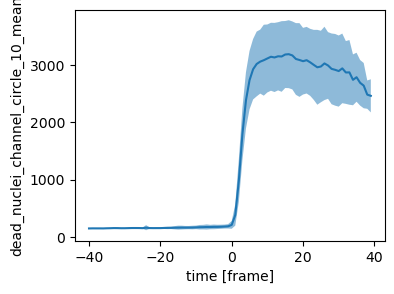

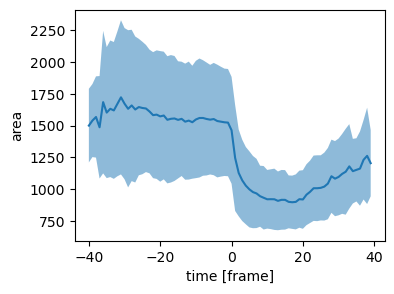

In [7]:
from celldetective.signals import mean_signal

feature = "dead_nuclei_channel_circle_10_mean"
cclass = 0
ms, std_signal, actual_timeline = mean_signal(df_class, feature, "class_lysis", time_col="t_lysis", class_value=[cclass], return_matrix=False, forced_max_duration=None, min_nbr_values=2)
fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.fill_between(actual_timeline, [a-b for a,b in zip(ms, std_signal)], [a+b for a,b in zip(ms, std_signal)], alpha=0.5)
ax.plot(actual_timeline, ms)
ax.set_xlabel("time [frame]")
ax.set_ylabel(feature)
plt.show()

feature = "area"
cclass = 0
ms, std_signal, actual_timeline = mean_signal(df_class, feature, "class_lysis", time_col="t_lysis", class_value=[cclass], return_matrix=False, forced_max_duration=None, min_nbr_values=2)
fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.fill_between(actual_timeline, [a-b for a,b in zip(ms, std_signal)], [a+b for a,b in zip(ms, std_signal)], alpha=0.5)
ax.plot(actual_timeline, ms)
ax.set_xlabel("time [frame]")
ax.set_ylabel(feature)
plt.show()

### Survival

Alternatively, we can exploit the $\Delta t$ between two events (here between the beginning of the movie at $T = 0$ and $t_\textrm{lysis}$) to define a survival function, showing the event rate and fraction of cells that exhibit the event.

convert to minutes! 2.75


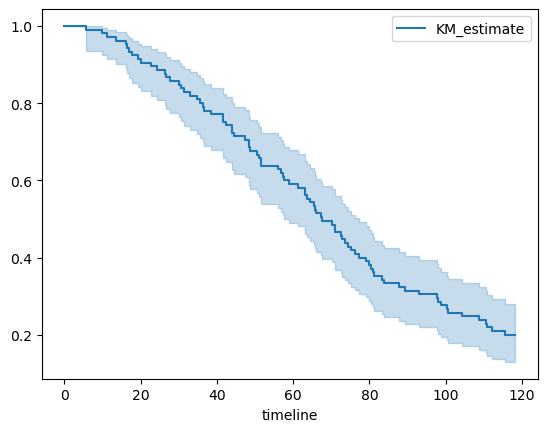

In [8]:
from celldetective.events import switch_to_events_v2
from lifelines import KaplanMeierFitter

classes = df_class.groupby('TRACK_ID')["class_lysis"].min().values
times = df_class.groupby('TRACK_ID')["t_lysis"].min().values
max_times = df_class.groupby('TRACK_ID')['FRAME'].max().values
left_censored = False

events, survival_times = switch_to_events_v2(classes, times, max_times, None, left_censored=left_censored, FrameToMin=FrameToMin)
ks = KaplanMeierFitter()
if len(events)>0:
    ks.fit(survival_times, event_observed=events)
    ks.plot_survival_function()